# Convolutional Neural Networks for Artwork recognition

In this section I created the input data for training:


*   I imported the individual artwork videos, and extracted a number of frames from each to be used as inputs to the CNN.  I used only 1 out of every 10 frames in each video, resulting in ~300-600 frames for each artwork. 
*   Each frame was resized to the resolution 224x224, as required by VGG19.

Add link to Tensorboard results here

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

num_classes = metadata.features['label'].num_classes
print(num_classes)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.
5


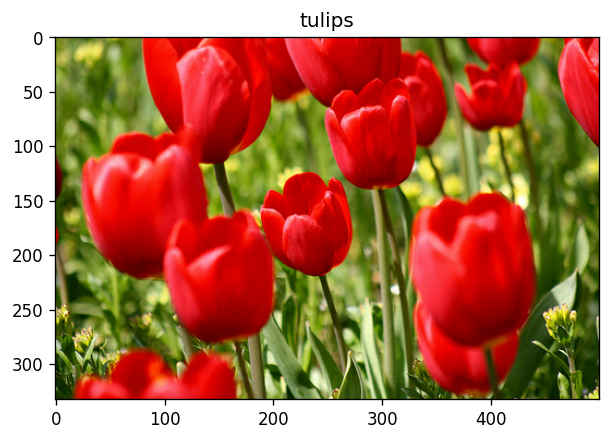

In [11]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


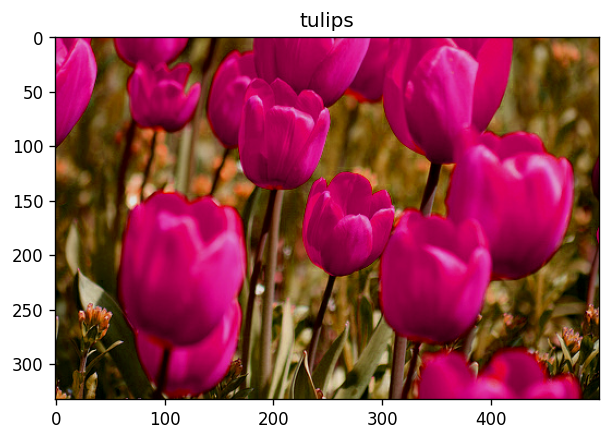

In [13]:
image, label = augment(*next(iter(train_ds)))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

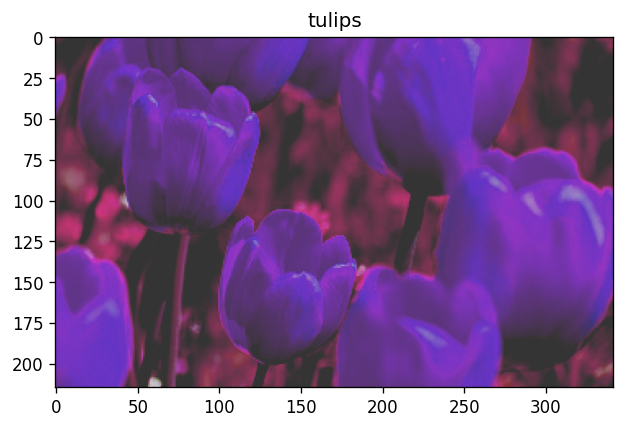

In [20]:
image, label = augment(image, label)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

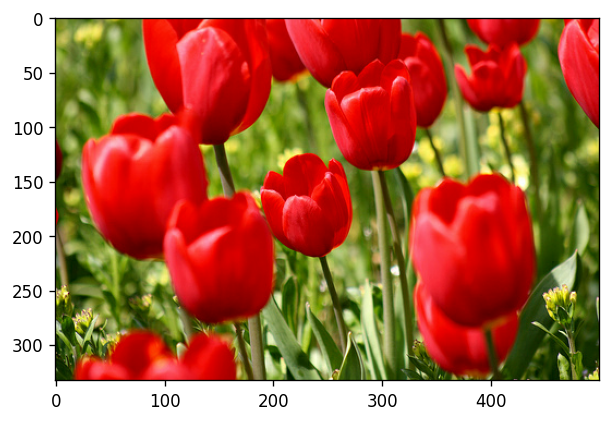

In [59]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)


In [60]:
image, label = augment(image, label)
_ = plt.imshow(image)


AttributeError: ignored

In [42]:
image.shape[0]

15

## Dataset generation from artwork videos

In [6]:
import cv2, math, os, pickle, random, sys
import numpy as np
import pandas as pd
import seaborn as sn
# %tensorflow_version 2.x
import tensorflow as tf

from datetime import datetime
from google.colab import drive
from google.colab.patches import cv2_imshow  # cv2_imshow is needed since cv2.imshow crashes jupyter notebooks
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D, LeakyReLU
from tensorflow.keras.layers import Conv2D, Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.layers.normalization import BatchNormalization
# from tensorflow.keras.layers.advanced_activations import
from typing import Tuple
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

# load the TensorBoard notebook extension
%load_ext tensorboard

# force installing the newest version of tensorflow-datasets, since Colab uses an older version
# !pip install tensorflow-datasets==4.0.0
# import tensorflow_datasets as tfds

# VGG19.preprocess_input
# tf.__version__
# tfds.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


The storage used below is a Google Drive folder, where I uploaded the artwork videos and related files. 

In [2]:
# mount storage (Google Drive) 
drive.mount("/content/drive", force_remount=True)

# sys.path.insert(0, "/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN")

base_dir = Path("/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN")
files_dir = base_dir / "contemporary_art_video_files"

Mounted at /content/drive


The functions in the following cells are used to generate Tensorflow datasets from the videos, by extracting frames and preprocessing them. 

In [3]:
def frame_generator(files_dir: Path, dataset_info: pd.DataFrame, max_frames: int, generate_by: str = "artwork"):
    """
    Extracts frames from the video files provided, and can be used as an input to create Tensorflow Datasets.

    Adapted from http://borg.csueastbay.edu/~grewe/CS663/Mat/LSTM/Exercise_VideoActivity_LSTM.html

    :param files_dir: path of the directory containing the videos
    :param dataset_info: pandas df containing the names of the videos and their corresponding labels
    :param max_frames: the total number of frames to extract; if fewer frames than requested are available,
     all frames for artwork/video will be extracted; if more are available, frames are extracted evenly from all
     frames available
    :param generate_by: whether to extract frames per artwork or per video, since an artwork may have multiple videos;
     should be either "artwork" or "video" only, any other value is ignored
    :return: frame generator
    """
    if generate_by not in ["artwork", "video"]:
        generate_by = "artwork"

    artwork_list = [artwork_id for artwork_id in sorted(dataset_info["id"].unique())]

    if generate_by == "artwork":
        for artwork_id in artwork_list:
            videos_for_artwork = [files_dir / row["file"] for _, row in
                                  dataset_info.loc[dataset_info["id"] == artwork_id].iterrows()]

            total_frames_for_artwork = sum(
                int(cv2.VideoCapture(str(v)).get(cv2.CAP_PROP_FRAME_COUNT)) for v in videos_for_artwork)

            # convert label to categorical array (of type tf.float32)
            label = tf.one_hot(artwork_list.index(artwork_id), len(artwork_list))

            sample_every_n_frame = max(1, total_frames_for_artwork // max_frames)

            current_frame = 0
            max_fr = max_frames

            for video_file in videos_for_artwork:
                cap = cv2.VideoCapture(str(video_file))

                while True:
                    success, frame = cap.read()

                    if not success:
                        break

                    if current_frame % sample_every_n_frame == 0:
                        frame = frame[:, :, ::-1]  # openCv reads frames in BGR format, convert to RGB
                        max_fr -= 1
                        yield tf.cast(frame, tf.float32), label

                        if max_fr <= 0:
                            break

                    current_frame += 1

    elif generate_by == "video":
        for _, row in dataset_info.iterrows():
            video_file = files_dir / row["file"]

            # label to categorical (type tf.float32)
            label = tf.one_hot(artwork_list.index(row["id"]), len(artwork_list))

            cap = cv2.VideoCapture(str(video_file))
            num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            sample_every_n_frame = max(1, num_frames // max_frames)

            current_frame = 0
            max_fr = max_frames

            while True:
                success, frame = cap.read()
                if not success:
                    break

                if current_frame % sample_every_n_frame == 0:
                    frame = frame[:, :, ::-1]  # openCv reads frames in BGR format, convert to RGB
                    max_fr -= 1
                    yield tf.cast(frame, tf.float32), label

                if max_fr == 0:
                    break

                current_frame += 1

In [4]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):
    """
    Splits a dataset of type tf.data.Dataset into a training and validation dataset using given ratio. Fractions are
    rounded up to two decimal places. From https://stackoverflow.com/a/59696126

    @param dataset: the input dataset to split
    @param validation_data_fraction: the fraction of the validation data as a float between 0 and 1
    @return: a tuple of two tf.data.Datasets as (training, validation)
    """
    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 > validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 <= validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

In [61]:
def dataset_from_videos(files_dir: Path, dataset_csv_info_file: str, max_frames: int = 750, batch_size: int = 128,
                        img_normalization_params: Tuple[float, float] = (0.0, 255.0), frame_size: int = 224,
                        train_val_test_percentages: Tuple[int, int, int] = (70, 30, 0)):
    """
    Generates train, validation and test tf.data.Datasets from the provided video files.

    :param files_dir: path of the directory containing the videos
    :param dataset_csv_info_file: name of csv file containing information about the videos, must be located in files_dir
    :param img_normalization_params: tuple of doubles (mean, standard_deviation) to use for normalizing the extracted
     frames, e.g. if (0.0, 255.0) is provided, the frames are normalized to the range [0, 1], see this comment for
     explanation of how to convert between the two https://stackoverflow.com/a/58096430
    :param max_frames: total number of frames to extract for each artwork
    :param frame_size: the size of the final resized square frames, this is dictated by the needs of the underlying NN
     that will be used in the training
    :param train_val_test_percentages: tuple specifying how to split the generated dataset into train, validation and
     test datasets, the provided ints must add up to 100
    :param batch_size: batch size for datasets
    :return: a tuple of train, validation and test tf.data.Datasets, as well as a list of the artworks ids
    """
    assert sum(train_val_test_percentages) == 100, "Split percentages must add up to 100!"

    dataset_info = pd.read_csv(files_dir / dataset_csv_info_file)

    # make sure all files in csv are present
    for _, row in dataset_info.iterrows():
        assert (files_dir / row["file"]).is_file(), "One or more of the video files don't exist"

    # sort artwork ids in alphabetical order, this is important as it determines how the CNN outputs its predictions
    artwork_dict = {artwork_id: i for i, artwork_id in enumerate(sorted(dataset_info["id"].unique()))}
    artwork_list = list(artwork_dict.keys())

    # create dataset, output_shapes are set to (None, None, 3), since the extracted frames are not initially resized,
    # to allow applying variations to the train dataset only below
    dt = tf.data.Dataset.from_generator(lambda: frame_generator(files_dir, dataset_info, max_frames),
                                        output_types=(tf.float32, tf.float32),
                                        output_shapes=((None, None, 3), (len(artwork_list))))

    # TODO calculate the datasets' sizes, perhaps print them, and also use them in the shuffling of the train dt below
    #  can be calculated like so: (num of classes * max_frames) * % of dataset

    # split into train, validation & test datasets
    train, val, test = train_val_test_percentages
    train_dataset, validation_and_test = split_dataset(dt, (val + test) / 100)
    validation_dataset, test_dataset = split_dataset(validation_and_test, test / (val + test))

    mean, std = img_normalization_params

    # apply necessary conversions (normalization, random modifications, batching & caching) to the created datasets
    # see https://www.tensorflow.org/datasets/keras_example for batching and caching explanation
    AUTO = tf.data.experimental.AUTOTUNE  # allows TF decide how to optimise dataset mapping below

    train_dataset = train_dataset \
        .map(augment, num_parallel_calls=AUTO) \
        .map(lambda x, y: (resize_and_rescale(x, fr_size=frame_size, mean=mean, std=std), y), num_parallel_calls=AUTO) \
        .cache() \
        .shuffle(1000) \
        .batch(batch_size) \
        .prefetch(AUTO)

    validation_dataset = validation_dataset \
        .map(lambda x, y: (resize_and_rescale(x, fr_size=frame_size, mean=mean, std=std), y), num_parallel_calls=AUTO) \
        .batch(batch_size) \
        .cache() \
        .prefetch(AUTO)

    test_dataset = test_dataset \
        .map(lambda x, y: (resize_and_rescale(x, fr_size=frame_size, mean=mean, std=std), y), num_parallel_calls=AUTO) \
        .batch(batch_size) \
        .cache() \
        .prefetch(AUTO)

    return train_dataset, validation_dataset, test_dataset, artwork_list


def resize_and_rescale(img, fr_size: int, mean: float, std: float):
    """
    Resizes frames to the desired shape and scale. See https://stackoverflow.com/a/58096430 for conversion explanation.
    """
    img = tf.image.resize(img, (fr_size, fr_size))
    return (tf.cast(img, tf.float32) - mean) / std


def augment(img, label):
    """ Applies random modifications to the frame provided. """
    if random.randint(0, 1):
        img = tf.image.random_crop(img, size=[int(img.shape[0] * random.uniform(0.3, 0.9)),
                                              int(img.shape[1] * random.uniform(0.3, 0.9)), 3])
    # img = tf.image.random_hue(img, 0.2)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_flip_left_right(img)

    return img, label


## CNN training

In [ ]:
def create_tensorboard_callback(model_name: str):
    log_dir = base_dir / "logs/fit" / f"{model_name}_{datetime.now().strftime('%Y%m%d%H%M')}"
    return tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [62]:
def vgg19(num_classes: int):
    vgg = VGG19(include_top=False, weights="imagenet", 
                        input_tensor=Input(shape=(224, 224, 3)))

    outputs = vgg.output
    outputs = Flatten(name="flatten")(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(num_classes, activation="softmax")(outputs)

    model = Model(inputs=vgg.input, outputs=outputs)

    for layer in vgg.layers:
        layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=['accuracy'])
    return model


def mobileNetV2(num_classes: int):
    mnv2 = MobileNetV2(include_top=False, weights="imagenet",
                       input_tensor=Input(shape=(224, 224, 3)))
    outputs = mnv2.output
    outputs = Flatten(name="flatten")(outputs)
    outputs = Dropout(0.5)(outputs)
    outputs = Dense(num_classes, activation="softmax")(outputs)

    model = Model(inputs=mnv2.input, outputs=outputs)

    for layer in mnv2.layers:
        layer.trainable = False

    model.compile(loss="categorical_crossentropy", optimizer="adam",
                    metrics=['accuracy'])
    return model

In [63]:
train_dt_vgg, validation_dt_vgg, test_dt_vgg, artwork_list = dataset_from_videos(files_dir, "description_export2.csv", 
                                                                                 50, img_normalization_params=(0.0, 255.0))



vgg = vgg19(len(artwork_list))

vgg_train_info = vgg.fit(train_dt_vgg, epochs=20, validation_data=validation_dt_vgg)

TypeError: ignored

In [ ]:
model_name = "vgg19NoArt300"
tb_callback_vgg = create_tensorboard_callback(model_name)

train_dt_vgg, validation_dt_vgg, test_dt_vgg, artwork_list = dataset_from_videos(files_dir, "description_export2.csv", 
                                                                                 (0.0, 255.0), 300, 224)

vgg = vgg19(len(artwork_list))

vgg_train_info = vgg.fit(train_dt_vgg, epochs=20, validation_data=validation_dt_vgg, callbacks=[tb_callback_vgg])

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/20
      1/Unknown - 0s 1ms/step - loss: 3.7253e-08 - accuracy: 1.0000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
28/28 [==============================] - 597s 21s/step - loss: 0.0139 - accuracy: 0.9983 - val_loss: 1.5727 - val_accuracy: 0.9553
Epoch 2/20
28/28 [==============================] - 15s 539ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 1.9101 - val_accuracy: 0.9451
Epoch 3/20
28/28 [==============================] - 15s 538ms/step - loss: 0.0017 - accuracy: 0.9997 - val_loss: 1.7456 - val_accuracy: 0.9508
Epoch 4/20
28/28 [==============================] - 15s 538ms/step - loss: 1.8866e-06 - accuracy: 1.0000 - val_loss: 1.6952 - val_accuracy: 0.9527
Epoch 5/20
28/2

In [ ]:
model_name = "mobileNetV2NoArt300"
tb_callback_mn = create_tensorboard_callback(model_name)

train_dt_mn, validation_dt_mn, test_dt_mn, artwork_list = dataset_from_videos(files_dir, "description_export2.csv", 
                                                                              (127.5, 127.5), 300, 224)
mnv2 = mobileNetV2(len(artwork_list))

model_train_info = mnv2.fit(train_dt_mn, epochs=20, validation_data=validation_dt_mn, callbacks=[tb_callback_mn])

Epoch 1/20
28/28 [==============================] - 595s 21s/step - loss: 22.0397 - accuracy: 0.5817 - val_loss: 10.8102 - val_accuracy: 0.6111
Epoch 2/20
28/28 [==============================] - 15s 534ms/step - loss: 0.9483 - accuracy: 0.9295 - val_loss: 3.2847 - val_accuracy: 0.9374
Epoch 3/20
28/28 [==============================] - 15s 536ms/step - loss: 0.0082 - accuracy: 0.9994 - val_loss: 3.1306 - val_accuracy: 0.9464
Epoch 4/20
28/28 [==============================] - 15s 537ms/step - loss: 1.9050e-06 - accuracy: 1.0000 - val_loss: 2.9679 - val_accuracy: 0.9489
Epoch 5/20
28/28 [==============================] - 15s 537ms/step - loss: 3.0279e-06 - accuracy: 1.0000 - val_loss: 2.9559 - val_accuracy: 0.9489
Epoch 6/20
28/28 [==============================] - 15s 537ms/step - loss: 3.0449e-06 - accuracy: 1.0000 - val_loss: 2.9526 - val_accuracy: 0.9489
Epoch 7/20
28/28 [==============================] - 15s 537ms/step - loss: 1.3555e-06 - accuracy: 1.0000 - val_loss: 2.9520 - val

In [ ]:
base_dir / "logs/fit"

PosixPath('/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN/logs/fit')

In [ ]:
!tensorboard dev upload \
  --logdir "/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN/logs/fit" \
  --name "CNNs for Modern art recognition" \
  --description "Two CNNs trained with 300 frames for each artwork, plus 300 for the no artwork category" \
  --one_shot


2020-10-16 14:20:37.425456: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/drive/My Drive/Colab Notebooks/Modern_Art_CNN/logs/fit

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleuserconten

In [ ]:
# n_videos = dataset.shape[0]
# max_frames_per_video = 100
# dataset_size = n_videos * max_frames_per_video

In [ ]:
# dt = tf.data.Dataset.from_generator(frame_generator_by_artwork, 
#                                     output_types=(tf.float32, tf.float32),
#                                     output_shapes=((224,224,3), (num_classes))) #.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# tfds.core.benchmark(dt, batch_size=32)

In [ ]:
# strategy = tf.distribute.MirroredStrategy()

In [ ]:

# evaluate model
test_eval = model.evaluate(data["tesX"], data["tesYhot"], verbose=1)

# get training info
accuracy = model_train_info.history['accuracy']
val_accuracy = model_train_info.history['val_accuracy']
loss = model_train_info.history['loss']
val_loss = model_train_info.history['val_loss']

# make predictions
predicted_classes = model.predict(data["tesX"])
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

# create classification report
target_names = class_list
report = classification_report(data["tesY"], predicted_classes, 
                        target_names=target_names, output_dict=True)
report = pd.DataFrame(report)

# create confusion matrix
cm = confusion_matrix(data["tesY"], predicted_classes)
df_cm = pd.DataFrame(cm, class_list, class_list)

# package results 
res = {"test_eval": test_eval, "accuracy": accuracy, 
        "val_accuracy": val_accuracy, "loss": loss, "val_loss": val_loss,
        "predicted_classes": predicted_classes, "test_Y": data["tesY"], 
        "test_X": data["tesX"], "confusion_matrix": df_cm, "report": report,
        "model": model}

print("Done!", flush=True)

NameError: ignored

## Results

### VGG19

### MobileNet

In [ ]:
# vgg19.evaluate(test_dataset)
predicted_classes = vgg19.predict(test_dataset)

In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

In [ ]:
predicted_classes

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  4

In [ ]:
labels = np.concatenate([label for _, label in test_dataset], axis=0)

In [ ]:
# labels are in categorical form (one_hot), convert them back
labels = np.argmax(labels, axis=1)
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  4

In [ ]:
dataset = pd.read_csv(files_dir / "description_export2.csv")

artwork_list = [artwork_id for _, artwork_id in enumerate(sorted(dataset["id"].unique()))]
artwork_list

['2-3_sfikas',
 'armament_phinikarides',
 'ascent_ladommatos',
 'autumn_chrysochos',
 'crucified_savvides',
 'game_of_shapes_chrysochos',
 'ground_plan_hadjida',
 'no_artwork',
 'presence_votsis',
 'secession_bargilly',
 'the_cyclist_votsis',
 'the_great_greek_encyclopaedia_makrides',
 'the_observer_kyriakou',
 'throne_ii_chrysochos',
 'untitled_hadjida',
 'untitled_kouroussis',
 'untitled_votsis']

In [ ]:
cm = confusion_matrix(labels, predicted_classes)
df_cm = pd.DataFrame(cm, artwork_list, artwork_list)
df_cm

,2-3_sfikas,armament_phinikarides,ascent_ladommatos,autumn_chrysochos,crucified_savvides,game_of_shapes_chrysochos,ground_plan_hadjida,no_artwork,presence_votsis,secession_bargilly,the_cyclist_votsis,the_great_greek_encyclopaedia_makrides,the_observer_kyriakou,throne_ii_chrysochos,untitled_hadjida,untitled_kouroussis,untitled_votsis
2-3_sfikas,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
armament_phinikarides,0,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ascent_ladommatos,0,0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0
autumn_chrysochos,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0,0
crucified_savvides,0,0,0,0,47,0,0,0,0,0,0,0,0,0,0,0,0
game_of_shapes_chrysochos,0,0,0,0,0,66,0,0,0,0,0,0,0,0,0,0,0
ground_plan_hadjida,0,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0,0
no_artwork,0,0,0,0,0,0,0,62,0,0,0,0,6,0,0,0,0
presence_votsis,0,0,0,0,0,0,0,0,34,0,0,0,0,0,0,0,0
secession_bargilly,0,0,0,0,0,0,0,0,0,68,0,0,0,0,0,0,0


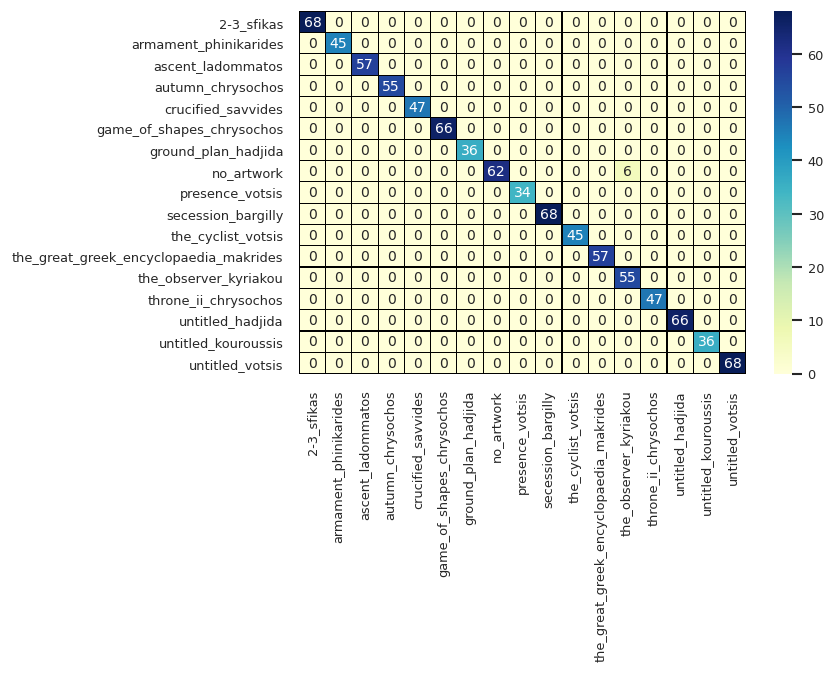

In [ ]:
sn.set(font_scale=.7)
sn.heatmap(df_cm, vmin=0, annot=True, 
            cmap="YlGnBu", fmt="d", 
            linewidths=0.1, linecolor="black")
plt.show()

In [ ]:
# save model
model_name = "MobileNet_No_Art"
saved_model_path = Path(base_dir, model_name, "saved_model")
mnv2.save(saved_model_path)

# Convert model to tflite

# first convert to normal tflite
converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_path))
tflite_model = converter.convert()

# second convert to quantized tflite
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

tflite_dir = base_dir / model_name / "tflite"
tflite_dir.mkdir(parents=True, exist_ok=True)

with tf.io.gfile.GFile(str(tflite_dir / f"{model_name}.tflite"), "wb") as f:
    f.write(tflite_model)

with tf.io.gfile.GFile(str(tflite_dir / f"{model_name}_quant.tflite"), "wb") as f:
    f.write(tflite_quant_model)

# save txt file with labels, ready for use in mobile device
labels_file = Path(tflite_dir, f"{model_name}_labels.txt")

# write to file
with open(labels_file, "w+") as f:
    for label in list(class_list):
        f.write(label + "\n")
print("Done!", flush=True)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Modern_Art_CNN/MobileNet_No_Art/saved_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Modern_Art_CNN/MobileNet_No_Art/saved_model/assets


Done!


# Older sections

## Input data processing

In [ ]:
# # install required dependency
# !pip install scikit-video

In [ ]:
# # process and save exported frames, will NOT recalculate if file already exists
# processed_file = files_dir / "processed"
# if not processed_file.is_file():
#     res = video_processing(files_dir)
#     with open(files_dir / "processed", "wb+") as f:
#         pickle.dump(res, f)

Import and process a .csv file that contains information about the video files.


In [ ]:
# dataset = pd.read_csv(files_dir / "description_export.csv")
# artwork_dict = {artwork_id: i for i, artwork_id in enumerate(sorted(dataset["id"].unique()))}
# num_classes = len(artwork_dict)
# class_list = artwork_dict.keys()

# for k, v in artwork_dict.items():
#     print(v, k)

## Create and train CNN

Function that splits the input data into train, validation, and test subsets.


Function to create and compile the ConvNet model.

Function that trains and evaluates the network.

In [ ]:
# def train_CNN(target_size, epochs=50, RGB=True, batch_size=64, verbose=1, 
#               convert_to_TFlite=True, show_summary=True, VGG19=True):
    
#     # if using VGG19, target_size must be 224
#     if VGG19: target_size = 224

#     # create model name
#     model_name = f"cnn{target_size}" 
#     if RGB: model_name += "RGB"
#     else: model_name += "grayscale"
#     if VGG19: model_name += "_VGG19"

#     # input_data_file = p_join(base_dir, model_name, f"{model_name}_data")

#     # dir structure for created files: 
#         # base_dir/model_name/model_name_data.csv
#         # base_dir/model_name/saved_model
#         # base_dir/model_name/tflite/model_name.tflite
#         # base_dir/model_name/tflite/model_name_labels.txt

#     # if not input_data_file.is_file() or force_photo_reprocessing:
#     #     # process photos
#     #     print("Processing photos to provided specifications...")
#     #     process_photos(input_data_file, target_size, RGB=RGB)
#     #     print("Done!")
#     # else:
#     #     # skip processing, already processed file exists
#     #     print("Photos already processed, skipping reprosessing.")

#     # load pickled file
#     # with open(files_dir / "processed", "rb") as f:
#     #     f.seek(0)
#     #     input_data_file = pickle.load(f)

#     # split dataset
#     print("Splitting dataset...", end=" ", flush=True)
#     data = split_data(files_dir / "processed")
#     print("Done!", flush=True)

#     # create and train CNN
#     print("Training neural network...")
#     if VGG19:
#         model = create_VGG19_CNN(target_size, RGB=RGB)

#         train_aug = ImageDataGenerator(
#             rotation_range=20,
#             width_shift_range=0.2,
#             height_shift_range=0.2,
#             horizontal_flip=True)
#         model_train_info = model.fit(train_aug.flow(data["trX"], data["trLab"], batch_size),
#                                      validation_data=(data["valX"], data["valLab"]),
#                                      epochs=epochs)
#     else:
#         model = create_conv_net_model(target_size, RGB=RGB)
#         model_train_info = model.fit(data["trX"], data["trLab"], batch_size, epochs,
#                                         verbose, validation_data=(data["valX"],
#                                                                 data["valLab"]))
#     print("Training complete.")

#     # evaluate model
#     print("Evaluating neural network...", end=" ", flush=True)
#     test_eval = model.evaluate(data["tesX"], data["tesYhot"], verbose=1)

#     # get training info
#     accuracy = model_train_info.history['accuracy']
#     val_accuracy = model_train_info.history['val_accuracy']
#     loss = model_train_info.history['loss']
#     val_loss = model_train_info.history['val_loss']

#     # make predictions
#     predicted_classes = model.predict(data["tesX"])
#     predicted_classes = np.argmax(np.round(predicted_classes), axis=1)

#     # create classification report
#     target_names = class_list
#     report = classification_report(data["tesY"], predicted_classes, 
#                             target_names=target_names, output_dict=True)
#     report = pd.DataFrame(report)

#     # create confusion matrix
#     cm = confusion_matrix(data["tesY"], predicted_classes)
#     df_cm = pd.DataFrame(cm, class_list, class_list)

#     # package results 
#     res = {"test_eval": test_eval, "accuracy": accuracy, 
#            "val_accuracy": val_accuracy, "loss": loss, "val_loss": val_loss,
#            "predicted_classes": predicted_classes, "test_Y": data["tesY"], 
#            "test_X": data["tesX"], "confusion_matrix": df_cm, "report": report,
#            "model": model}

#     print("Done!", flush=True)

#     # save model
#     saved_model_path = Path(base_dir, model_name, "saved_model")
#     model.save(saved_model_path)

#     # Convert model to tflite
#     if convert_to_TFlite:
#         print("Converting neural network to TFLite...", end=" ", flush=True)

#         # first convert to normal tflite
#         converter = tf.lite.TFLiteConverter.from_saved_model(str(saved_model_path))
#         tflite_model = converter.convert()

#         # second convert to quantized tflite
#         converter.optimizations = [tf.lite.Optimize.DEFAULT]
#         tflite_quant_model = converter.convert()

#         tflite_dir = Path(base_dir) / model_name / "tflite"
#         tflite_dir.mkdir(parents=True, exist_ok=True)
        
#         with tf.io.gfile.GFile(str(tflite_dir / f"{model_name}.tflite"), "wb") as f:
#             f.write(tflite_model)

#         with tf.io.gfile.GFile(str(tflite_dir / f"{model_name}_quant.tflite"), "wb") as f:
#             f.write(tflite_quant_model)

#         # save txt file with labels, ready for use in mobile device
#         labels_file = Path(tflite_dir, f"{model_name}_labels.txt")

#         # write to file
#         with open(labels_file, "w+") as f:
#             for label in list(class_list):
#                 f.write(label + "\n")
#         print("Done!", flush=True)

#     # show results
#     if show_summary:
#         print('Test loss:', test_eval[0])
#         print('Test accuracy:', test_eval[1])

#     return res

### Training

The CNN was trained for only 20 epochs, which proved to be more than enough. We can extend the training later if needed.

In [ ]:
# cnn224RGB_VGG19 = train_CNN(224, epochs=20, VGG19=True)

## Results

### Training history

In [ ]:
# epochs = 20
# ep = range(epochs)
# plt.plot(ep, cnn224RGB_VGG19["accuracy"], "bo",  label='Training accuracy')
# plt.plot(ep, cnn224RGB_VGG19["val_accuracy"], "b",  label='Validation accuracy')
# plt.xlabel("Epochs")
# plt.title("Training and validation accuracy")
# plt.legend()

# plt.figure()

# plt.plot(ep, cnn224RGB_VGG19["loss"], "bo", label='Training loss', color ="red")
# plt.plot(ep, cnn224RGB_VGG19["val_loss"], "b", label='Validation loss', color ="red")
# plt.xlabel("Epochs")
# plt.title("Training and validation loss")
# plt.legend()
# plt.show()

### Confusion matrix

In [ ]:
# cm = confusion_matrix(cnn224RGB_VGG19["test_Y"], cnn224RGB_VGG19["predicted_classes"])
# df_cm = pd.DataFrame(cm, class_list, class_list)
# sn.set(font_scale=.7)
# sn.heatmap(df_cm, vmin=0, annot=True, 
#             cmap="YlGnBu", fmt="d", 
#             linewidths=0.1, linecolor="black")
# plt.show()

### Summary

In [ ]:
# from IPython.display import HTML, display
# import tabulate
# pd.options.display.float_format = '{:,.3f}'.format
# print( "Test accuracy:", cnn224RGB_VGG19["test_eval"][1], "\n\nTest loss:", cnn224RGB_VGG19["test_eval"][0], "\n")
# display(HTML(cnn224RGB_VGG19["report"].to_html()))

### Prediction examples

In [ ]:
# target_size = 224
# class_dict_rev = {v:k for k, v in artwork_dict.items()}
# correct = np.where(cnn224RGB_VGG19["predicted_classes"]==cnn224RGB_VGG19["test_Y"])[0]
# print(f"Found {len(correct)} correct labels")
# for i, correct in enumerate(correct[:9]):
#   pred, actual = class_dict_rev[cnn224RGB_VGG19['predicted_classes'][correct]], class_dict_rev[cnn224RGB_VGG19['test_Y'][correct]]
#   plt.subplot(3,3,i+1)
#   plt.imshow(cnn224RGB_VGG19["test_X"][correct].reshape(target_size, target_size, 3), cmap='gray', interpolation='none')
#   plt.grid(None)
#   plt.title(f"pred: {pred}, actual: {actual}")
#   plt.tight_layout()

In [ ]:
# incorrect = np.where(cnn64["predicted_classes"]!=cnn64["test_Y"])[0]
# print(f"Found {len(incorrect)} incorrect labels")
# for i, incorrect in enumerate(incorrect[:9]):
#   pred, actual = class_dict_rev[cnn64['predicted_classes'][incorrect]], class_dict_rev[cnn64['test_Y'][incorrect]]
#   plt.subplot(3,3,i+1)
#   plt.imshow(cnn64["test_X"][incorrect].reshape(target_size, target_size), cmap='gray', interpolation='none')
#   plt.grid(None)
#   plt.title(f"pred: {pred}, actual: {actual}")
#   plt.tight_layout()

## Testing (NOT UPDATED FOR MODERN ART)

In [ ]:
# interpreter = tf.lite.Interpreter(model_path=os.path.join(base_dir,"saved_models","cnn64RGB.tflite"))
# interpreter.allocate_tensors()

In [ ]:
# with open(fp, "r") as f:
#     processed = pd.read_csv(f)

# processed.shape

In [ ]:
# input_details = interpreter.get_input_details()
# output_details = interpreter.get_output_details()

# # Test the converted tflite model with original dataset
# predictions=[]
# for i in range(1,processed.shape[0]):
#     input_data = processed.iloc[i-1:i,:-1].to_numpy().reshape(-1,64,64,3).astype("float32")/255.
#     actual = processed.iloc[i-1:i,-1:].to_numpy()[0]

#     interpreter.set_tensor(input_details[0]['index'], input_data)

#     interpreter.invoke()

#     # The function `get_tensor()` returns a copy of the tensor data.
#     # Use `tensor()` in order to get a pointer to the tensor.
#     output_data = interpreter.get_tensor(output_details[0]['index'])
    
#     predictions.append(output_data.argmax() == actual)
#     # print(i, "predicted", output_data.argmax(), "actual", actual)

# print("Correctly identified photos:",f"{sum(predictions)[0]}/{processed.shape[0]}", 
#       f"({sum(predictions)[0]/processed.shape[0]:.2%})")

In [ ]:
# # test with original photos that have only 1 label each, without cropping

# one_label = dataset['photo'].value_counts()[lambda x: x==1].index.tolist()

# photos_1_label = dataset[dataset['photo'].isin(one_label)]
# photos_1_label.shape

# predictions_1_label=[]

# for i, row in photos_1_label.iterrows():
#     # get photo
#     photo_array = cv2.imread(os.path.join(photo_dir, row["photo"]))

#     # crop and resize
#     photo_array = cv2.resize(photo_array, (64, 64), interpolation=cv2.INTER_AREA)

#     input_data = photo_array.reshape(-1,64,64,3).astype("float32")/255.
#     actual = class_dict[row["class"]]
#     if i < 40:
#         print(input_data)
#     interpreter.set_tensor(input_details[0]['index'], input_data)

#     interpreter.invoke()

#     # The function `get_tensor()` returns a copy of the tensor data.
#     # Use `tensor()` in order to get a pointer to the tensor.
#     output_data = interpreter.get_tensor(output_details[0]['index'])
    
#     predictions_1_label.append(output_data.argmax() == actual)
#     # print(i, "predicted", output_data.argmax(), "actual", actual)

# print("Correctly identified photos:",f"{sum(predictions_1_label)}/{photos_1_label.shape[0]}", 
#       f"({sum(predictions_1_label)/photos_1_label.shape[0]:.2%})")

In [ ]:
# from glob import glob

# for model in glob(os.path.join(base_dir,"saved_models","*.tflite"),recursive=True):
#     interpreter = tf.lite.Interpreter(model)
#     interpreter.allocate_tensors()
#     input_details = interpreter.get_input_details()
#     print(os.path.split(model)[1],"\n", interpreter.get_input_details(),"\n",interpreter.get_output_details())

In [ ]:
# pip install tflite-support